In [307]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [308]:
# Load dataset
df = pd.read_csv(r"C:\Users\danie\Kaggle\archive\weatherAUS.csv")
df.info()
# We can see there are a lot of columns with missing values.
# To keep things simple we will drop the columns with missing values and see what we have left.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [309]:
df = df.dropna()
df.shape
# We still have 56000 observations, we may not need to impute missing values. We will see how we do.

(56420, 23)

In [310]:
# Let's instead use our data to predict what the weather will be like today. This avoids data leakage, since the
# way the problem was framed prior was using information in the future, information we wouldn't have access too.
# However, if we frame the problem in this way, all the information we're using is in the past, information we would
# have access too.
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

In [311]:
# The probability of it raining in one location in Australia can vary from location to location. This would require a more
# complex model that would adapt to local weather patterns. We should see if we can narrow it down to a smaller region.

# These location are within 20km of each other. They would have similar local weather patterns. Let's group these and use
# their data.
df = df[df["Location"].isin(["Melbourne", "MelbourneAirport", "Watsonia"])]
df.shape

# 7500 observation should be enough to provide a reasonably good model.

(7557, 23)

In [312]:
# We can create a more useful feature than time by splitting it into seasons.
# Since Australia is in the southern hemisphere, the season are as follows:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return "Summer"
    elif (month == 3) or (month == 4) or (month == 5):
        return "Autumn"
    elif (month == 6) or (month == 7) or (month == 8):
        return "Winter"
    elif (month == 9) or (month == 10) or (month == 11):
        return "Spring"

In [313]:
# Convert date column to type datetime so we can access the .month method
df["Date"] = pd.to_datetime(df["Date"])

# We take the values from df[Date] and apply the function date_to_season to them. Those output values will then be stored in Season
df["Season"] = df["Date"].apply(date_to_season)

# Drop the Date column
df.drop(columns=["Date"], inplace=True)

In [314]:
# Split dependent variable from independent variables
X = df.drop(columns=["RainToday"])
y = df["RainToday"]

In [315]:
# Check how unbalanced our target variable is
y.value_counts()
# Unbalanced, we will have to take this into account when splitting and using cross validation

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

In [316]:
# We use stratify=y to maintain class the original class distribution in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# get the names of the numerical and categorical features from the training set.
numerical_features = X_train.select_dtypes(include=["number"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

# Numerical pipeline
num_preprocessor = Pipeline([
    ("scaler", StandardScaler()),
])

# Categorical pipeline
cat_preprocessor = Pipeline([
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

# Concatenate outputs from num_processor and cat_processor to get find processed feature matrix
preprocessor = ColumnTransformer([
    ("num", num_preprocessor, numerical_features),
    ("cat", cat_preprocessor, categorical_features),
])

# Define pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42)),
])

In [ ]:
# Define the parameters we want grid search to try
param_grid = {
    "classifier__n_estimators":[50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

# Since classes are imbalanced, we can use StratifiedKFold to main class distribution amongst folds.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Gridsearch
best_model_RF = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')

# Train the pipeline using the best hyperparameters.
best_model_RF.fit(X_train, y_train)

In [288]:
print(f"Best parameters: {best_model_RF.best_params_}, \nBest score: {best_model_RF.best_score_:.2f}")

Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}, 
Best score: 0.85


In [289]:
Accuracy_RF = best_model_RF.score(X_test, y_test)
print(f"Accuracy on test set: {Accuracy_RF:.2f}%")
# So we are expecting our model to predict whether it will rain today correctly 84% of the time
# Let's analyze this closer.

Accuracy on test set: 0.84%


In [290]:
# Make predictions on unseen data.
y_pred_RF = best_model_RF.predict(X_test)

              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



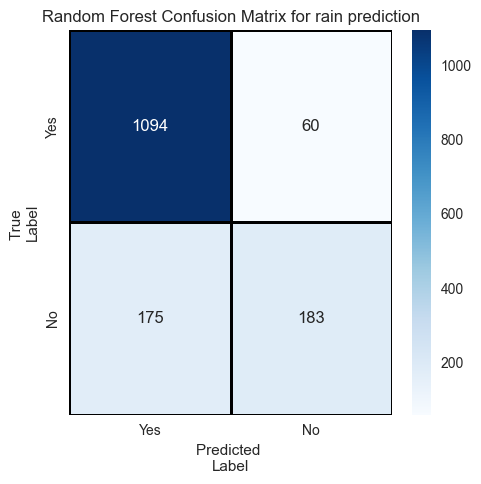

In [291]:
# Print the classification report.
print(classification_report(y_test, y_pred_RF))

# Get confusion matrix and label names
conf_matrix = confusion_matrix(y_test, y_pred_RF)
labels = y.unique()

# Define heatmap
plt.figure(figsize=[5, 5])
sns.heatmap(conf_matrix,
            annot=True,
            cmap="Blues",
            fmt="g",
            xticklabels=labels,
            yticklabels=labels,
            linewidths=2,
            linecolor='black',)

# Labels and titles
plt.xlabel("Predicted \nLabel")
plt.ylabel("True \nLabel")
plt.title("Random Forest Confusion Matrix for rain prediction")

# Plot heatmap
plt.tight_layout()
plt.show()

In [292]:
# Extract feature importances
feature_importances = best_model_RF.best_estimator_["classifier"].feature_importances_

# Extract one-hot encoded names
one_hot_encoded_names = best_model_RF.best_estimator_["preprocessor"].named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(categorical_features)

# Concatenate the numerical and one-hot encoded categorical features to give all features names.
feature_names = list(numerical_features) + list(one_hot_encoded_names)

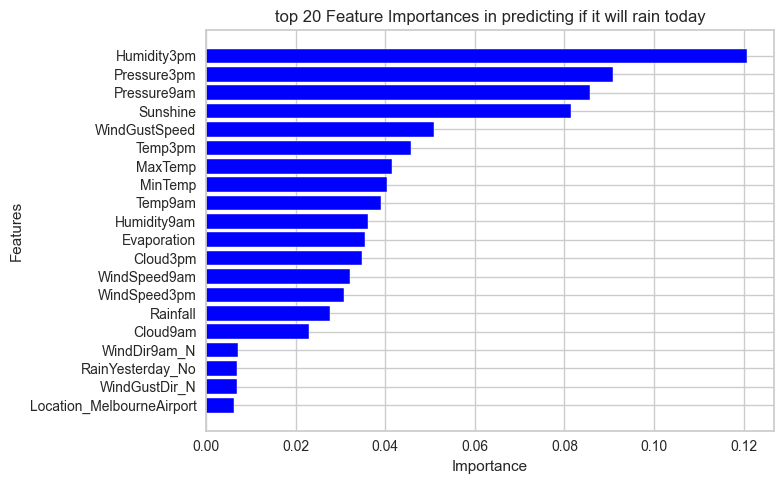

In [293]:
# convert to Dataframe
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "importance": feature_importances,
}).sort_values(by="importance", ascending=False)

N = 20
top_features = importances_df.head(N)

# Define the fig and horizontal bar chart
plt.figure(figsize=[8, 5])
plt.barh(top_features["Feature"], top_features["importance"], color="blue")

# Invert axis so higher values are on top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title(f"top {N} Feature Importances in predicting if it will rain today")

# Plot the bar chart
plt.tight_layout()
plt.show()

In [294]:
# Replace Random forest classifier step in pipeline with Logistic Regression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# Define the parameters we want grid search to try
param_grid_LR = {
    "classifier__class_weight": [None, "balanced"],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver":["liblinear"]
}

# Define gridsearch
best_model_LR = GridSearchCV(pipeline, param_grid_LR, cv=cv, scoring='accuracy')

# Train pipeline with these best hyperparameters
best_model_LR.fit(X_train, y_train)

# Compute accuracy on unseen data.
Accuracy_LR = best_model_LR.score(X_test, y_test)
print(f"Accuracy on test set: {Accuracy_LR:.2f}%")

Accuracy on test set: 0.83%


              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.69      0.51      0.59       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



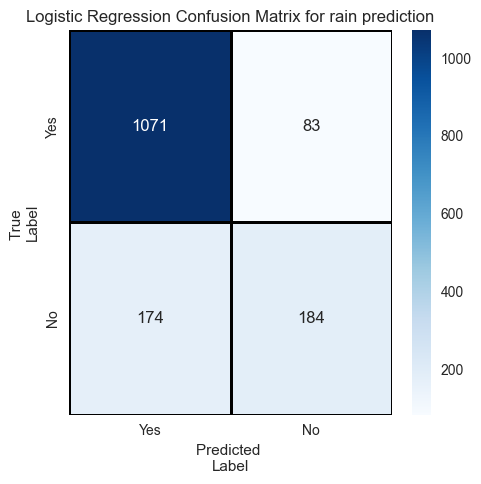

In [295]:
# Make predictions
y_pred_LR = best_model_LR.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_LR))

# Get confusion matrix and label names
conf_matrix = confusion_matrix(y_test, y_pred_LR)
labels = y.unique()

# Define heatmap
plt.figure(figsize=[5, 5])
sns.heatmap(conf_matrix,
            annot=True,
            cmap="Blues",
            fmt="g",
            xticklabels=labels,
            yticklabels=labels,
            linewidths=2,
            linecolor='black',)

# Labels and titles
plt.xlabel("Predicted \nLabel")
plt.ylabel("True \nLabel")
plt.title("Logistic Regression Confusion Matrix for rain prediction")

# Plot heatmap
plt.tight_layout()
plt.show()


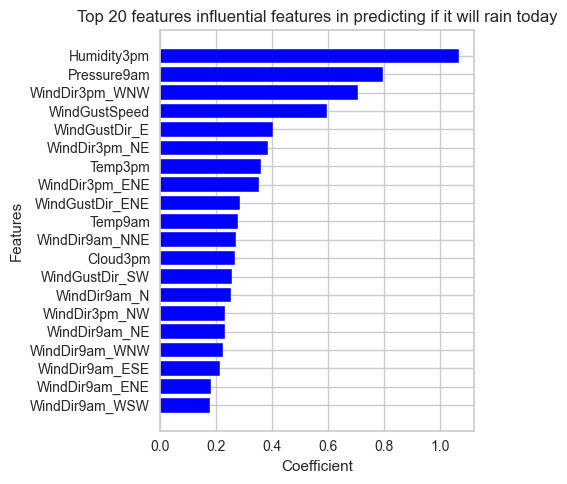

In [296]:
# Extract learned coefficients
coefficients = best_model_LR.best_estimator_["classifier"].coef_[0]

# Convert to dataframe
importances_LR_df = pd.DataFrame({
    "coefficient": coefficients,
    "feature": feature_names,
}).sort_values(by=["coefficient"], ascending=False)

# We have many coefficients, we can change this value to see the top N features
N = 20
top_features_LR = importances_LR_df.head(N)

# Plot the horizontal barchart
plt.figure(figsize=[5, 5])
plt.barh(top_features_LR["feature"], top_features_LR["coefficient"].abs(), color="blue")

# Invert y-axis such that the larget coefficient is on top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel("Coefficient")
plt.ylabel("Features")
plt.title(f"Top {N} features influential features in predicting if it will rain today")

# Plot horizontal barchart
plt.tight_layout()
plt.show()


In [306]:
# We can see a lot of the same features in the top 20 influential features for LR and RF.
class_report_RF = classification_report(y_test, y_pred_RF, output_dict=True)
class_report_LR = classification_report(y_test, y_pred_LR, output_dict=True)

# Accuracy for RF and LR
print(f"Accuracy for RF: {Accuracy_RF:.2f}, Accuracy for LR: {Accuracy_LR:.2f}")

# Weighted average precision for RF and LR
print(f"Precision average RF: {class_report_RF['weighted avg']['precision']:.2f},"
      f"Precision average LR: {class_report_LR['weighted avg']['precision']:.2f}")

# Weighted average recall for RF and LR
print(f"Recall average RF: {class_report_RF['weighted avg']['recall']:.2f},"
      f" Recall average LR: {class_report_LR['weighted avg']['recall']:.2f}")

# Weighted average f1-score for RF and LR
print(f"f1-score average RF: {class_report_RF['weighted avg']['f1-score']:.2f},"
      f" f1-score average LR: {class_report_LR['weighted avg']['f1-score']:.2f}")

# Overall, whilst our RF and LR models have the same TPR, our RF classifier performs slightly better
# than our LR classifier with higher accuracy and higher average weighted precision, recall, and f1-score.

Accuracy for RF: 0.84, Accuracy for LR: 0.83
Precision average RF: 0.84,Precision average LR: 0.82
Recall average RF: 0.84, Recall average LR: 0.83
f1-score average RF: 0.83, f1-score average LR: 0.82
